# Step 2: Detecting Peaks
Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

Peak detection is a common problem in time-series analysis. In some cases, they are very easy to spot by eye, but that can be difficult to define mathematically. This is particularly true for signals that are “noisy” or have pronounced variations in their baseline values. There are several Python libraries out there for automatically identifying peaks in time-series data, such as [`findpeaks.py`](https://erdogant.github.io/findpeaks/pages/html/index.html) and [`PeakUtils`](https://peakutils.readthedocs.io/en/latest/). In `hplc-py`, peak detection is executed using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) which is very mature and actively maintained. In this notebook, we won’t cover the algorithms used under-the-hood for peak detection, but will outline how `hplc-py` leverages `scipy.signal.find_peaks` and `scipy.signal.peak_widths` to 1) identify peaks in chromatographic data and 2) clip the chromatogram into discrete peak windows which are used in the fitting procedure.

## Selecting peaks by topographic prominence
Peaks are defined by a handful of quantitative properties. The most relevant 
to `hplc-py` is the [topographic prominence](https://en.wikipedia.org/wiki/Topographic_prominence), 
which is a measure of the relative height of a maxima in the signal to its nearest 
baseline.  For chromatographic data, peaks are often highly pronounced relative
to their surrounding signal, except in two limits:

1) The concentration of the analyte is close to the sensitivity limit of the 
detector 
2) The peak overlaps with a nearby peak which is much higher in concentration, 
drowning out or completely subsuming the signal.

As an example, we can load a real chromatogram of a [minimal medium for 
bacterial growth](https://www.sigmaaldrich.com/US/en/product/sigma/m9956) 
which has a slew of compounds, some of which overlap.

(10.0, 20.0)

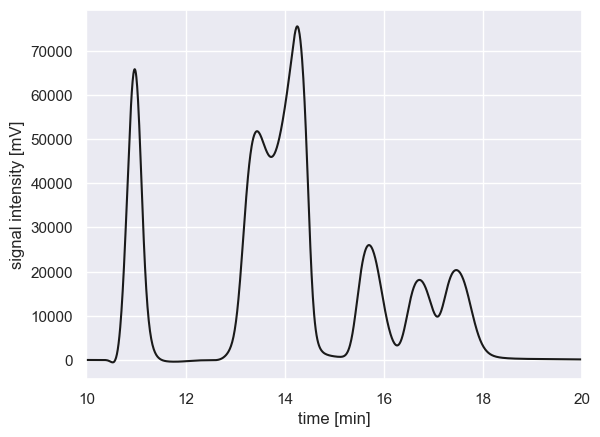

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load a sample chromatogram and show the trace, cropped between 10 and 20 minutes
df = pd.read_csv('data/sample_chromatogram.txt')
plt.plot(df['time_min'], df['intensity_mV'], 'k-')
plt.xlabel('time [min]')
plt.ylabel('signal intensity [mV]')
plt.xlim([10, 20])

With this signal, the location of peaks (meaning, the index where a local maxima is 
detected) can be identified using `scipy.signal.find_peaks`, even with a very 
low prominence filter. TO allow prominence filters to be comparable between 
chromatograms, we normalize the chromatogram first between 0 and 1.

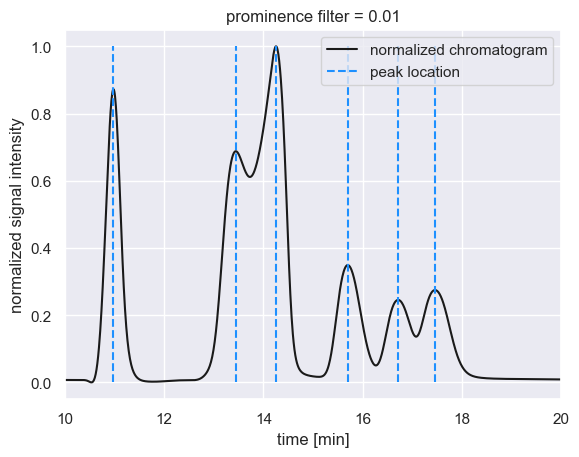

In [2]:
import scipy.signal

# Create a normalized signal
signal_norm = (df['intensity_mV'] - df['intensity_mV'].min()) / (df['intensity_mV'].max() - df['intensity_mV'].min())

# Find peaks with a low prominence filter of 0.01
peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=0.01)

# Plot the  original trace and overlay vertical lines with location of peaks
plt.plot(df['time_min'], signal_norm, 'k-', label='normalized chromatogram')
plt.vlines(df['time_min'].values[peak_locations], 0, 1, linestyle='--', 
           color='dodgerblue', label='peak location')
plt.xlabel('time [min]')
plt.ylabel('normalized signal intensity')
plt.xlim([10, 20])
plt.title('prominence filter = 0.01')
plt.legend()

These maxima have prominence values greater than or equal to 0.01, meaning that 
maxima with prominences as low as 0.01 units above the local background are considered 
to be bonafide peaks. Increasing the prominence filter begins to remove peaks 
we would otherwise care about.

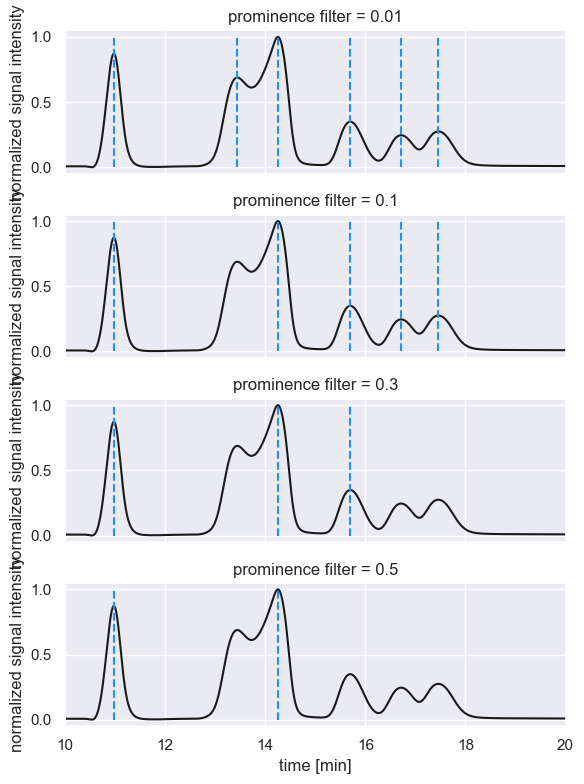

In [3]:
# Plot the  original trace and overlay vertical lines with location of peaks
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
for a in ax:
    a.plot(df['time_min'], signal_norm, 'k-')
    a.set_ylabel('normalized signal intensity')

# Plot for a few promincne values
for i, p in enumerate([0.01, 0.1, 0.3, 0.5]): 
    peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=p) 
    ax[i].vlines(df['time_min'].values[peak_locations], 0, 1, linestyle='--', color='dodgerblue')
    ax[i].set_title(f'prominence filter = {p}')

# Add necessary labels
ax[3].set_xlabel('time [min]')
ax[2].set_xlim([10, 20])
plt.tight_layout()

The choice of a prominence filter is going to be dependent on the size of peaks 
that you care to resolve in your chromatogram, their degree of overlap, and how 
noisy your signal is. The prominence filter can be passed as a keyword argument 
in the `fit_peaks` method of a `Chromatogram`. For example, passing a restrictive 
prominence filter of `0.1` can be done as follows:

Performing baseline correction:   0%|          | 0/299 [00:00<?, ?it/s]

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time_min', ylabel='intensity_mV (baseline corrected)'>]

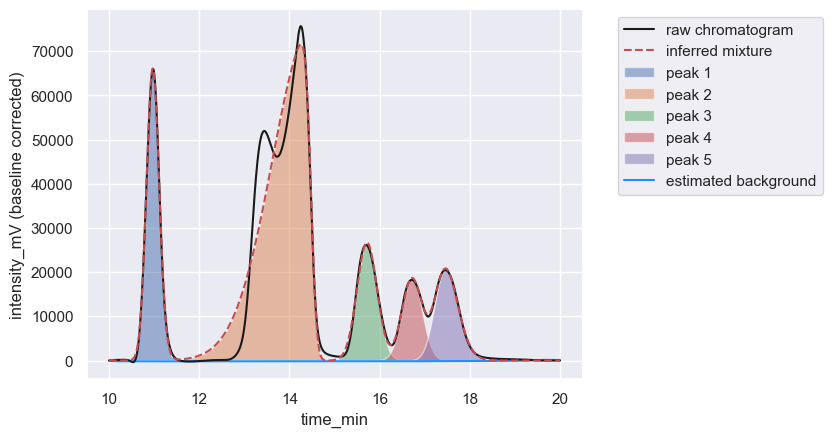

In [4]:
from hplc.quant import Chromatogram

# Load the signal trace as a Chromatogram object and crop between 10 and 20 min.
chrom = Chromatogram(df, cols={'time':'time_min', 'signal':'intensity_mV'},
                     time_window=[10, 20])

# Pass a prominence filter, fit the peaks, and show the result
peaks = chrom.fit_peaks(prominence=0.1)
chrom.show()

Note that even though the small peak at ≈ 13 minutes was not detected by the prominence filter, 
`hplc-py` still attempted to fit its signal as if it was part of the peak with a 
maximum at ≈ 14.2 min. This because the small peak was considered part 
of the same window of the major peak, as we will explore next.

## Clipping the signal into `peak windows`
Once peak maxima are identified, `hplc-py` slices the chromatograms into *windows*–regions 
of the chromatogram where peaks are overlapping or *nearly* overlapping. This 
is achieved by measuring the widths of each peak at the lowest [contour line](https://en.wikipedia.org/wiki/Contour_line).
Peaks which have overlapping contour lines are considered to be close enough that their signals may be influencing one another. 
This is achieved under the hood in a method `_assign_peak_windows` of a `Chromatogram`
which is called as part of `fit_peaks`. 

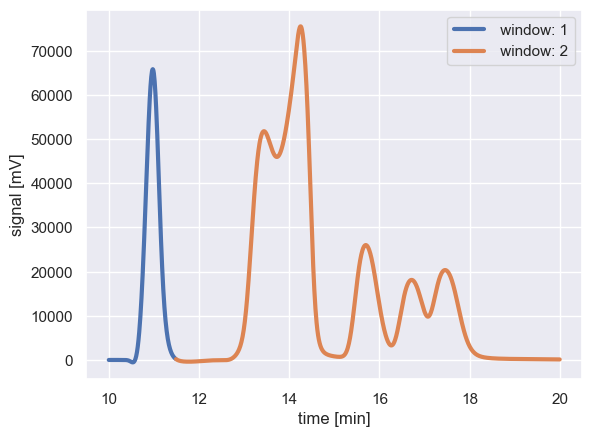

In [5]:
# Fit the peaks using a permissive prominence filter 
window_df = chrom._assign_windows(prominence=0.01)

# Plot each window
for g, d in window_df.groupby('window_id'):
    plt.plot(d['time_min'], d['intensity_mV'], '-', lw=3, label=f' window: {g}') 
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')

plt.legend()

Peaks within each colored region are considered to be interacting signals, and 
are fit together as one unit. In the above example, the peak at ≈ 11 min (in window 1) 
is considered to be isolated from the peaks at ≈ 13 min onward. 

The extent of each peak window can be controlled by a buffer parameter passed 
to `fit_peaks` and `_assign_windows`. This, given in units of time points, extends each peak window 
on to account for nearby baseline signal. The above windows can be shrunk by 
reducing this parameter, which has a default value of `75`.

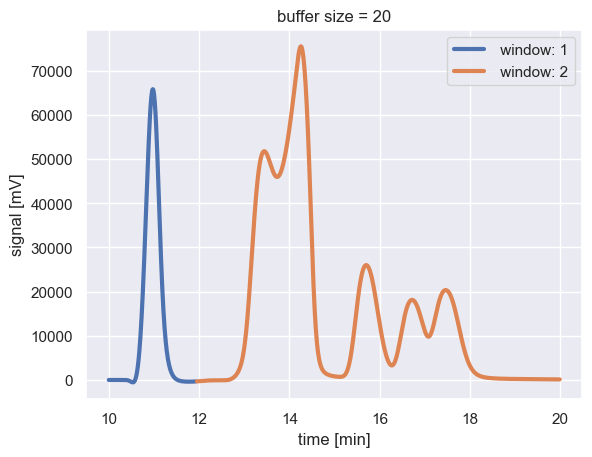

In [6]:
# Shrink the buffer and plot the change in the peak window.
buffer = 20
window_df = chrom._assign_windows(prominence=0.01, buffer=buffer)

# Plot each window
for g, d in window_df.groupby('window_id'):
    plt.plot(d['time_min'], d['intensity_mV'], '-', lw=3, label=f' window: {g}') 
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')
plt.title(f'buffer size = {buffer}')
plt.legend()

Note that shrinking the buffer size trimmed back the extent of the orange window
by half a minute or so.

Once the chromatogram is clipped into peak windows, each window is passed 
to an inference stage where the peak mixture is inferred.

---

<small> © Griffin Chure, 2023. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>
